In [1]:
import pandas as pd
import numpy as np
import json
import gzip
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.types import *



In [2]:
# Create Spark session 
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName('test') \
    .getOrCreate()

sc = spark.sparkContext

23/06/01 11:50:00 WARN Utils: Your hostname, MBP.local resolves to a loopback address: 127.0.0.1; using 192.168.0.29 instead (on interface en0)
23/06/01 11:50:00 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/01 11:50:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Meta electronics file for price data

[PySpark — Read Compressed gzip files](https://subhamkharwal.medium.com/pyspark-read-compressed-gzip-files-1d219ff3cdff)

In [3]:
# 1.2 GB compressed gz file
# df_zipped = spark \
#     .read \
#     .format("json") \
#     .option("compression", "gzip") \
#     .load("meta_Electronics.json.gz")

# df_zipped.printSchema()


Chek partitions:

In [4]:
# df_zipped.rdd.getNumPartitions()

Unzip file:

In [5]:
# %%sh

# gzip -d meta_Electronics.json.gz
# ls -lhtr

View first few rows of JSON:

In [6]:
N = 3
with open("meta_Electronics.json") as f:
    for i in range(0,N):
        print(f.readline(), end = '')

{"category": ["Electronics", "Camera &amp; Photo", "Video Surveillance", "Surveillance Systems", "Surveillance DVR Kits"], "tech1": "", "description": ["The following camera brands and models have been tested for compatibility with GV-Software.\nGeoVision \tACTi \tArecont Vision \tAXIS \tBosch \tCanon\nCNB \tD-Link \tEtroVision \tHikVision \tHUNT \tIQEye\nJVC \tLG \tMOBOTIX \tPanasonic \tPelco \tSamsung\nSanyo \tSony \tUDP \tVerint \tVIVOTEK \t \n \nCompatible Standard and Protocol\nGV-System also allows for integration with all other IP video devices compatible with ONVIF(V2.0), PSIA (V1.1) standards, or RTSP protocol.\nONVIF \tPSIA \tRTSP \t  \t  \t \nNote: Specifications are subject to change without notice. Every effort has been made to ensure that the information on this Web site is accurate. No liability is assumed for incidental or consequential damages arising from the use of the information or products contained herein."], "fit": "", "title": "Genuine Geovision 1 Channel 3rd P

Load into spark dataframe and print schema:

In [7]:
df_unzipped = spark \
    .read \
    .format("json") \
    .load("meta_Electronics.json")

df_unzipped.printSchema()

23/06/01 11:50:24 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


root
 |-- also_buy: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- also_view: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- asin: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- category: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- date: string (nullable = true)
 |-- description: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- details: struct (nullable = true)
 |    |-- \n    Item Weight: \n    : string (nullable = true)
 |    |-- \n    Package Dimensions: \n    : string (nullable = true)
 |    |-- \n    Product Dimensions: \n    : string (nullable = true)
 |    |--  Date first listed on Amazon:: string (nullable = true)
 |    |--  UNSPSC Code:: string (nullable = true)
 |    |-- ASIN:: string (nullable = true)
 |    |-- ASIN: : string (nullable = true)
 |    |-- Batteries: string (nullable = true)
 |    |-- Cards:: string (nullable = true)
 |   

Loads but takes 22 seconds without schema.

Check partitions:

In [8]:
df_unzipped.rdd.getNumPartitions()

82

In [25]:
print((df_unzipped.count(), len(df_unzipped.columns)))

(786445, 19)


Looks like a few hundred rows are missing (minor %). Website lists 786,868 products

Look at data:

In [9]:
df_unzipped.show()

+--------------------+--------------------+----------+--------------------+--------------------+------------------+--------------------+-------+--------------------+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+-----+--------------------+
|            also_buy|           also_view|      asin|               brand|            category|              date|         description|details|             feature|fit|            imageURL|     imageURLHighRes|            main_cat|               price|                rank|        similar_item|tech1|tech2|               title|
+--------------------+--------------------+----------+--------------------+--------------------+------------------+--------------------+-------+--------------------+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+-----+--------------------+
|            

Pick columns we want:

In [10]:
cols_to_use = ['asin', 'brand', 'date', 'main_cat', 'price', 'title']
df_unzipped.select(cols_to_use).show()

+----------+--------------------+------------------+--------------------+--------------------+--------------------+
|      asin|               brand|              date|            main_cat|               price|               title|
+----------+--------------------+------------------+--------------------+--------------------+--------------------+
|0011300000|           GeoVision|  January 28, 2014|  Camera &amp; Photo|              $65.00|Genuine Geovision...|
|0043396828|        33 Books Co.|     June 17, 2003|  Camera &amp; Photo|                    |Books "Handbook o...|
|0060009810|Visit Amazon's Ca...|                  |               Books|              $11.49|      One Hot Summer|
|0060219602|Visit Amazon's Di...|                  |               Books|.a-section.a-spac...|Hurray for Hattie...|
|0060786817|Visit Amazon's Lo...|                  |               Books|              $13.95|sex.lies.murder.f...|
|0070524076|Visit Amazon's Al...|                  |               Books

### Electronics data subset (5-core)

Was having issues loading from zip:

In [11]:
# # 5 core electronics data
# df_zipped = spark \
#     .read \
#     .format("json") \
#     .option("compression", "gzip") \
#     .load("Electronics_5.json.gz")

# df_zipped.printSchema()

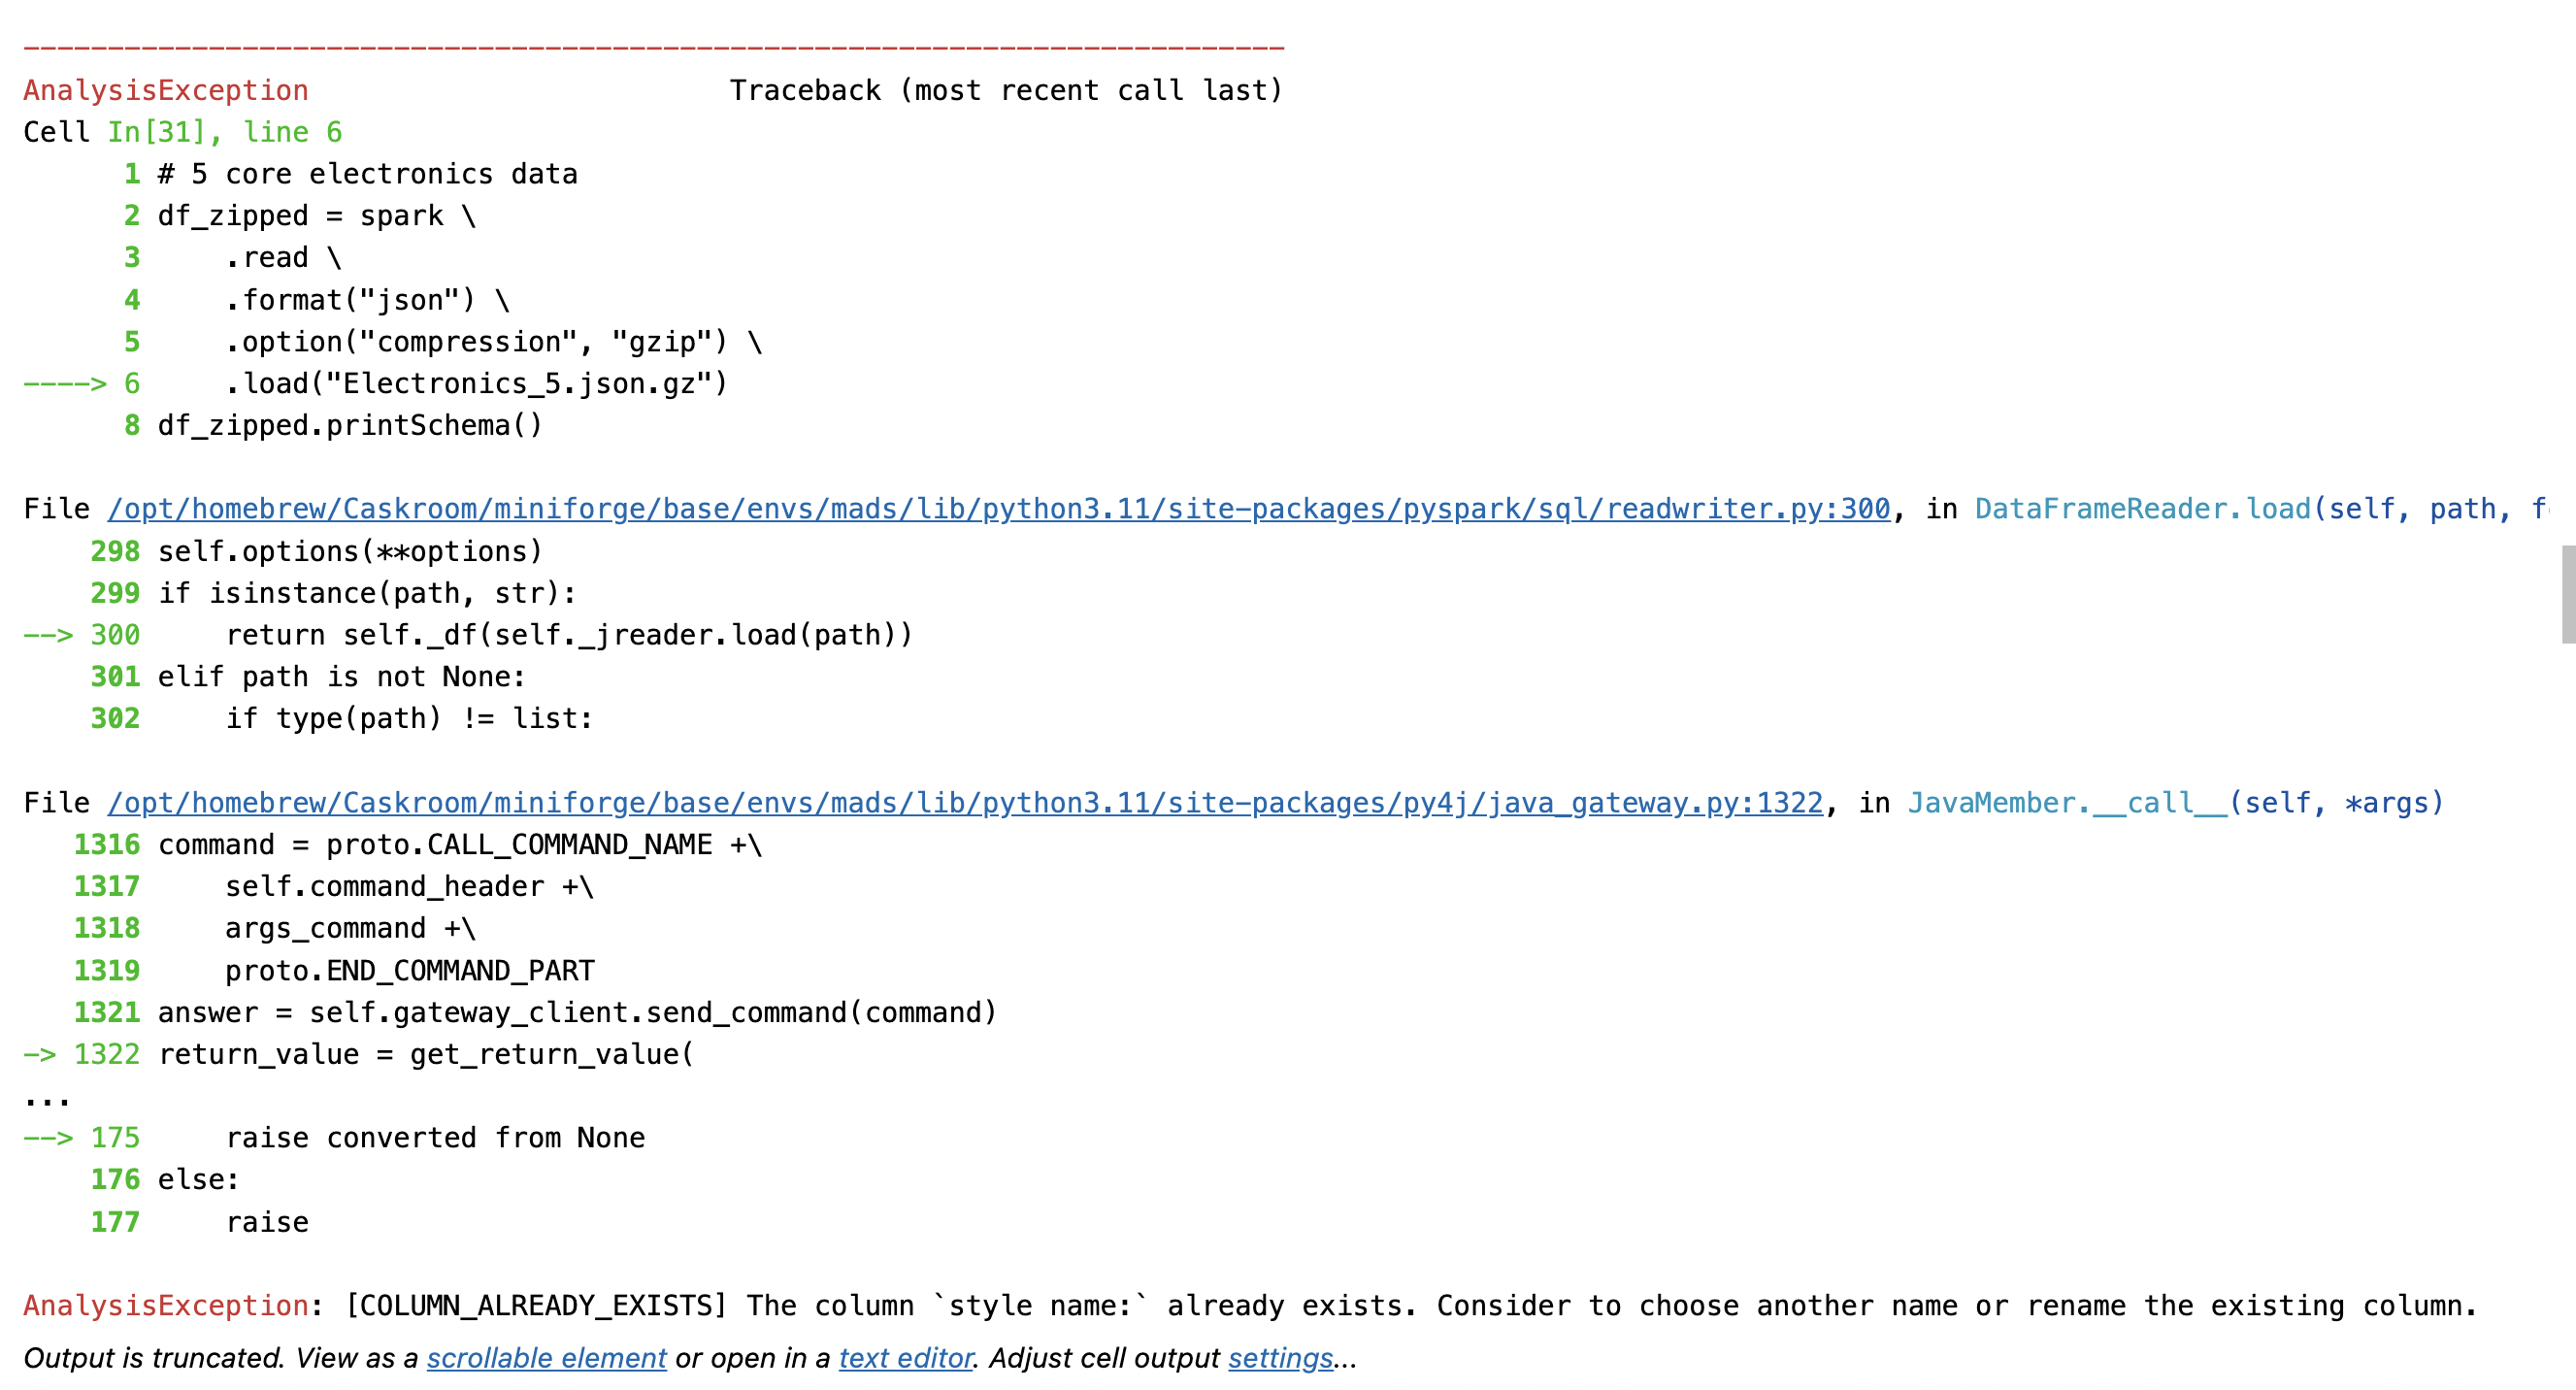

Unzipped the 1.25 GB .json.gz file to 4.19GB .json file:

In [12]:
# %%sh

# gzip -d Electronics_5.json.gz
# ls -lhtr

Same error loading from JSON:

In [13]:
# e5_core_df = spark \
#     .read \
#     .format('json') \
#     .load("Electronics_5.json")

# e5_core_df.printSchema()

Read first few lines of JSON: 

In [14]:
# Loading entire 4 gig file into 8GB of available ram...not good.....major slow downs.

N = 3
with open("Electronics_5.json") as f:
    for i in range(0,N):
        print(f.readline(), end = '')


{"overall": 5.0, "vote": "67", "verified": true, "reviewTime": "09 18, 1999", "reviewerID": "AAP7PPBU72QFM", "asin": "0151004714", "style": {"Format:": " Hardcover"}, "reviewerName": "D. C. Carrad", "reviewText": "This is the best novel I have read in 2 or 3 years.  It is everything that fiction should be -- beautifully written, engaging, well-plotted and structured.  It has several layers of meanings -- historical, family,  philosophical and more -- and blends them all skillfully and interestingly.  It makes the American grad student/writers' workshop \"my parents were  mean to me and then my professors were mean to me\" trivia look  childish and silly by comparison, as they are.\nAnyone who says this is an  adolescent girl's coming of age story is trivializing it.  Ignore them.  Read this book if you love literature.\nI was particularly impressed with  this young author's grasp of the meaning and texture of the lost world of  French Algeria in the 1950's and '60's...particularly poig

Copy first row of JSON output above and use [Schema Generator](https://preetranjan.github.io/pyspark-schema-generator/) to create schema below:

In [15]:
schema = StructType([StructField('overall',FloatType(),True),  # Changed to FloatType from StringType
    StructField('vote',StringType(),True),  
    StructField('verified',BooleanType(),True),  
    StructField('reviewTime',StringType(),True),  
    StructField('reviewerID',StringType(),True),  
    StructField('asin',StringType(),True),  
    StructField('style',StructType([StructField('Format:',StringType(),True)]),True),  
    StructField('reviewerName',StringType(),True),  
    StructField('reviewText',StringType(),True),  
    StructField('summary',StringType(),True),  
    StructField('unixReviewTime',IntegerType(),True)])

Use schema so spark does not have to infer:

In [16]:
# 5 core electronics data
e5_core_df = spark \
    .read \
    .json("Electronics_5.json", schema = schema)

e5_core_df.printSchema()

root
 |-- overall: float (nullable = true)
 |-- vote: string (nullable = true)
 |-- verified: boolean (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- style: struct (nullable = true)
 |    |-- Format:: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: integer (nullable = true)



Show data:

In [17]:
e5_core_df.show()

+-------+----+--------+-----------+--------------+----------+-----------------+--------------------+--------------------+--------------------+--------------+
|overall|vote|verified| reviewTime|    reviewerID|      asin|            style|        reviewerName|          reviewText|             summary|unixReviewTime|
+-------+----+--------+-----------+--------------+----------+-----------------+--------------------+--------------------+--------------------+--------------+
|    5.0|  67|    true|09 18, 1999| AAP7PPBU72QFM|0151004714|     { Hardcover}|        D. C. Carrad|This is the best ...|      A star is born|     937612800|
|    3.0|   5|    true|10 23, 2013|A2E168DTVGE6SV|0151004714|{ Kindle Edition}|                 Evy|Pages and pages o...|A stream of consc...|    1382486400|
|    5.0|   4|   false| 09 2, 2008|A1ER5AYS3FQ9O3|0151004714|     { Paperback}|               Kcorn|This is the kind ...|I'm a huge fan of...|    1220313600|
|    5.0|  13|   false| 09 4, 2000|A1T17LMQABMBN5|01

Check partitions:

In [21]:
e5_core_df.rdd.getNumPartitions()

32

Check shape:

In [24]:
print((e5_core_df.count(), len(e5_core_df.columns)))

(6739590, 11)


Same number of rows as described on dataset website.

Next up is to merge price with the data subset on `asin`.

### Load directly from gzip? 
So we can load directly from the zipped file if we use the schema:

In [18]:
# 5 core electronics data
test_df = spark \
    .read \
    .format("json") \
    .option("compression", "gzip") \
    .load("Electronics_5.json.gz", schema = schema) # Use schema

test_df.show()

+-------+----+--------+-----------+--------------+----------+-----------------+--------------------+--------------------+--------------------+--------------+
|overall|vote|verified| reviewTime|    reviewerID|      asin|            style|        reviewerName|          reviewText|             summary|unixReviewTime|
+-------+----+--------+-----------+--------------+----------+-----------------+--------------------+--------------------+--------------------+--------------+
|    5.0|  67|    true|09 18, 1999| AAP7PPBU72QFM|0151004714|     { Hardcover}|        D. C. Carrad|This is the best ...|      A star is born|     937612800|
|    3.0|   5|    true|10 23, 2013|A2E168DTVGE6SV|0151004714|{ Kindle Edition}|                 Evy|Pages and pages o...|A stream of consc...|    1382486400|
|    5.0|   4|   false| 09 2, 2008|A1ER5AYS3FQ9O3|0151004714|     { Paperback}|               Kcorn|This is the kind ...|I'm a huge fan of...|    1220313600|
|    5.0|  13|   false| 09 4, 2000|A1T17LMQABMBN5|01

Check number of partitions:

In [19]:
test_df.rdd.getNumPartitions()

1

Spark uses only a single core to read the whole gzip file, thus there is no distribution or parallelization.

https://stackoverflow.com/questions/40492967/dealing-with-a-large-gzipped-file-in-spark

### Slack:

[Project Team / Mentor "standup" meeting] As we move beyond the comprehensive exam I'd like to encourage teams to contact their 593 mentors and schedule a meeting next week (~ 30 min) to discuss the current state of your team project and upcoming work. Consider asking yourselves the following questions:
- Workflow: what are the current priorities for the team and is progress being made?
- Blockers: are there any impediments slowing or preventing progress?
- Refinements: what can we improve as a team (processes, workflow, etc.)

### Up next
- Finish ETL pipline - merge data
- What exactly are we looking for?
- Git, et cetera